In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [14]:
# Create a list with the filepaths for training and testing
dir_ = Path('Datasets/SIBI_SL/')


ext = ['jpeg', 'jpg', 'png']    # Add image formats here

files = []
file_paths = []
dir_ = Path("C:\\Users\\rizky\\Datasets")
[files.extend(list(dir_.glob(r"**/**/*" + e )) for e in ext)]
for i in range(len(files)):
    file_paths.extend(files[i])
print(len(file_paths))

295879


In [15]:
#Number of pictures and different labels in dataset
def proc_img(filepath):

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    print(labels.unique())
    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(file_paths)

print(f'Number of pictures in the dataset: {df.shape[0]}\n')
print(f'Number of different labels in the dataset: {len(df.Label.unique())}\n')
# print(f'Labels: {df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
df.head(10)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S'
 'T' 'U' 'V' 'W' 'X' 'Y' 'J' 'nothing' 'space' 'Z' 'del']
Number of pictures in the dataset: 295879

Number of different labels in the dataset: 29



,Filepath,Label
0,C:\Users\rizky\Datasets\SIBI_SL\train\K\K2181 ...,K
1,C:\Users\rizky\Datasets\SIBI_SL\train\G\G2221.jpg,G
2,C:\Users\rizky\Datasets\SIBI_SL\train\N\761.jpg,N
3,C:\Users\rizky\Datasets\SIBI_SL\train\S\S795 (...,S
4,C:\Users\rizky\Datasets\SIBI_SL\train\J\J2701 ...,J
5,C:\Users\rizky\Datasets\SIBI_SL\train\X\X2915 ...,X
6,C:\Users\rizky\Datasets\SIBI_SL\train\S\1974.jpg,S
7,C:\Users\rizky\Datasets\SIBI_SL\train\Z\Z2249 ...,Z
8,C:\Users\rizky\Datasets\SIBI_SL\train\L\2189.jpg,L
9,C:\Users\rizky\Datasets\SIBI_SL\train\L\545.jpg,L


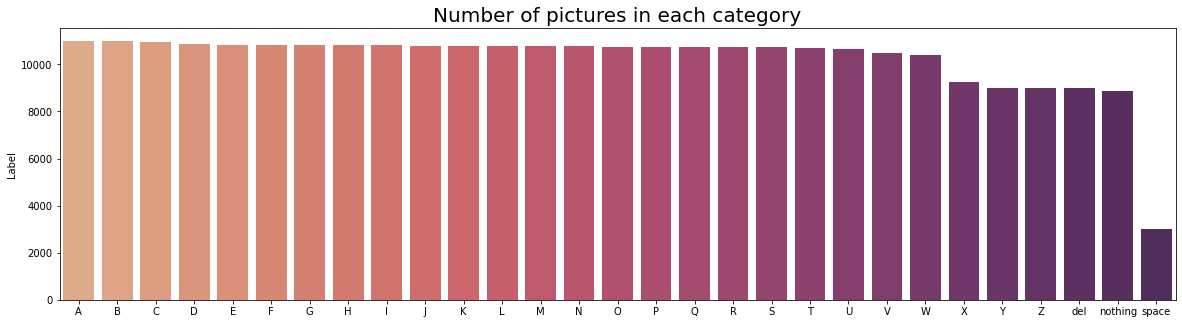

In [16]:
vc = df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "flare")
plt.title("Number of pictures in each category", fontsize = 20)
plt.show()

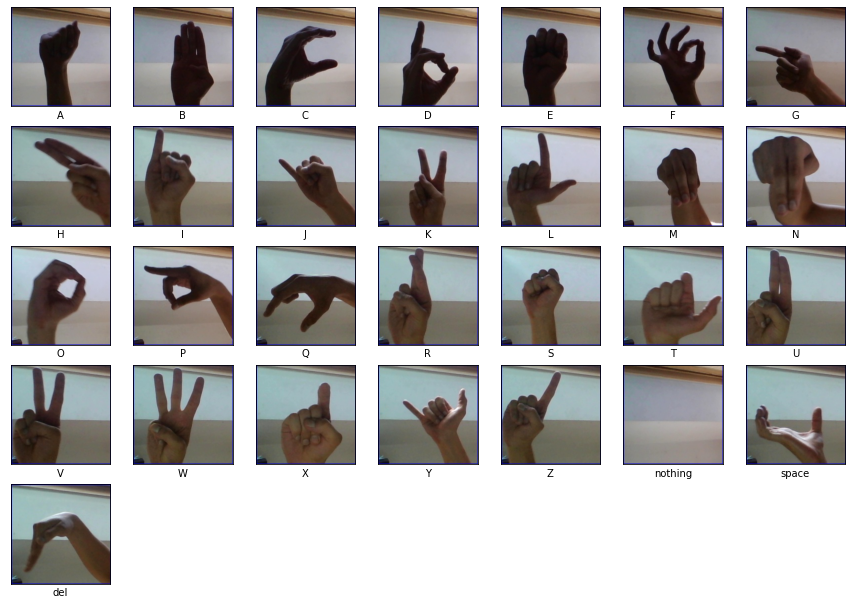

In [17]:
#Display all pictures unique labels
train_dir = os.path.join(str(dir_),"SIBI_SL/train")
test_dir = os.path.join(str(dir_),"SIBI_SL/test")

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del' ]

plt.figure(figsize=(15, 15))

for i in range (0,29):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path = train_dir + "/{0}/{0}1.jpg".format(classes[i])
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(classes[i])

In [18]:
train_df, test_df = train_test_split(df,test_size=0.05, random_state=42)

In [19]:
print(len(train_df))
print(len(test_df))

281085
14794


In [20]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    validation_split=0.1
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=45, # Uncomment to use data augmentation
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=45, # Uncomment to use data augmentation
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256,
    shuffle=False
)

Found 252977 validated image filenames belonging to 29 classes.
Found 28108 validated image filenames belonging to 29 classes.
Found 14794 validated image filenames belonging to 29 classes.


In [21]:
kwargs =    {'input_shape':(150, 150, 3),
            'include_top':False,
            'weights':'imagenet',
            'pooling':'avg'}
pretrained_model = tf.keras.applications.InceptionV3(**kwargs)
pretrained_model.trainable = False

inputs = pretrained_model.input

x = layers.Dense(128, activation='relu')(pretrained_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)  
outputs = layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=1,
                            restore_best_weights=True)]
                    )


Epoch 1/5
989/989 [==============================] - 1881s 2s/step - loss: 0.3546 - accuracy: 0.8948 - val_loss: 0.1045 - val_accuracy: 0.9677
Epoch 2/5
989/989 [==============================] - 1225s 1s/step - loss: 0.1027 - accuracy: 0.9672 - val_loss: 0.0956 - val_accuracy: 0.9707
Epoch 3/5
989/989 [==============================] - 1223s 1s/step - loss: 0.0708 - accuracy: 0.9772 - val_loss: 0.0673 - val_accuracy: 0.9786
Epoch 4/5
989/989 [==============================] - 1230s 1s/step - loss: 0.0558 - accuracy: 0.9820 - val_loss: 0.0538 - val_accuracy: 0.9845
Epoch 5/5
989/989 [==============================] - 1226s 1s/step - loss: 0.0485 - accuracy: 0.9839 - val_loss: 0.0665 - val_accuracy: 0.9794


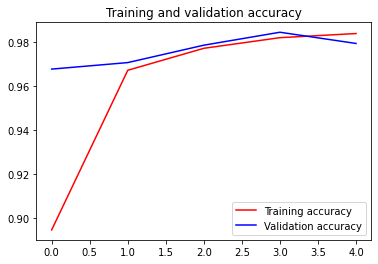

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [24]:
##save model
model.save("model.h5")

In [32]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('signLanguage2.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\rizky\AppData\Local\Temp\tmpf2lmnt9w\assets


INFO:tensorflow:Assets written to: C:\Users\rizky\AppData\Local\Temp\tmpf2lmnt9w\assets


In [33]:
#Convert to int8
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] 
tflite_quant_model = converter.convert()
with open('signLanguage2_int8.tflite', 'wb') as f:
  f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\rizky\AppData\Local\Temp\tmpjc2614cx\assets


INFO:tensorflow:Assets written to: C:\Users\rizky\AppData\Local\Temp\tmpjc2614cx\assets


In [34]:
#Convert to a float16 quantization
converter.target_spec.supported_types = [tf.float16]
tflite_fp16_model = converter.convert()
#Save the model
with open('signLanguage2_f16.tflite', 'wb') as f:
  f.write(tflite_fp16_model)

INFO:tensorflow:Assets written to: C:\Users\rizky\AppData\Local\Temp\tmpae9e3cot\assets


INFO:tensorflow:Assets written to: C:\Users\rizky\AppData\Local\Temp\tmpae9e3cot\assets
